In [ ]:
import os
import shutil
import random
from pathlib import Path
from collections import Counter, defaultdict
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam


# EDA

In [2]:
base_dir = Path("D:/binus/semester 4/Deep Learning/UTS/Nomor 2")
train_dir = Path("D:/binus/semester 4/Deep Learning/UTS/Nomor 2/Training")
test_dir = Path("D:/binus/semester 4/Deep Learning/UTS/Nomor 2/Testing")

In [72]:
# data information
for dirpath, dirnames, filenames in os.walk(train_dir):
    print(f"directories: {len(dirnames)}\nimages: {len(filenames)}\npath:'{dirpath}'")
for dirpath, dirnames, filenames in os.walk(test_dir):
    print(f"directories: {len(dirnames)}\nimages: {len(filenames)}\npath:'{dirpath}'")


directories: 4
images: 0
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Training'
directories: 0
images: 1321
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Training\glioma'
directories: 0
images: 1339
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Training\meningioma'
directories: 0
images: 1595
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Training\notumor'
directories: 0
images: 1457
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Training\pituitary'
directories: 4
images: 0
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Testing'
directories: 0
images: 300
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Testing\glioma'
directories: 0
images: 306
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Testing\meningioma'
directories: 0
images: 405
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Testing\notumor'
directories: 0
images: 300
path:'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Testing\pituitary'


In [4]:
class_names = sorted([item.name for item in train_dir.iterdir() if item.is_dir()])
print("Class Names:", class_names)

Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
# data distribution train test data
train_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        train_counts[class_name] = len(os.listdir(class_path))

test_counts = {}
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        test_counts[class_name] = len(os.listdir(class_path))

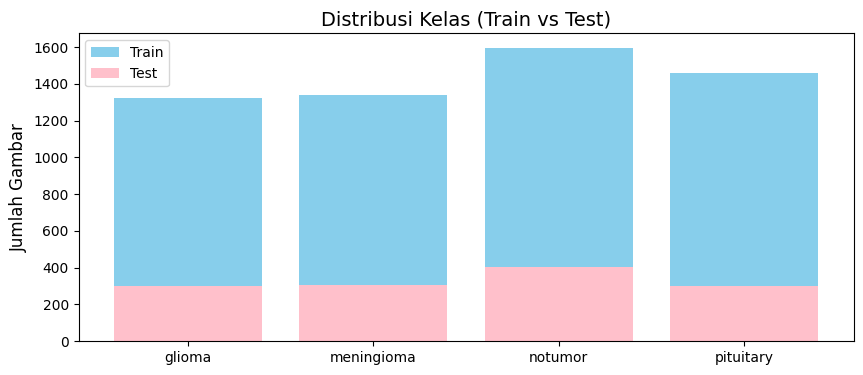

In [74]:
plt.figure(figsize=(10,4))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue', label='Train')
plt.bar(test_counts.keys(), test_counts.values(), color='pink', label='Test')
plt.title("Distribusi Kelas (Train vs Test)", size=14)
plt.ylabel("Jumlah Gambar",size=12)
plt.legend()
plt.show()

Found 5712 files belonging to 4 classes.


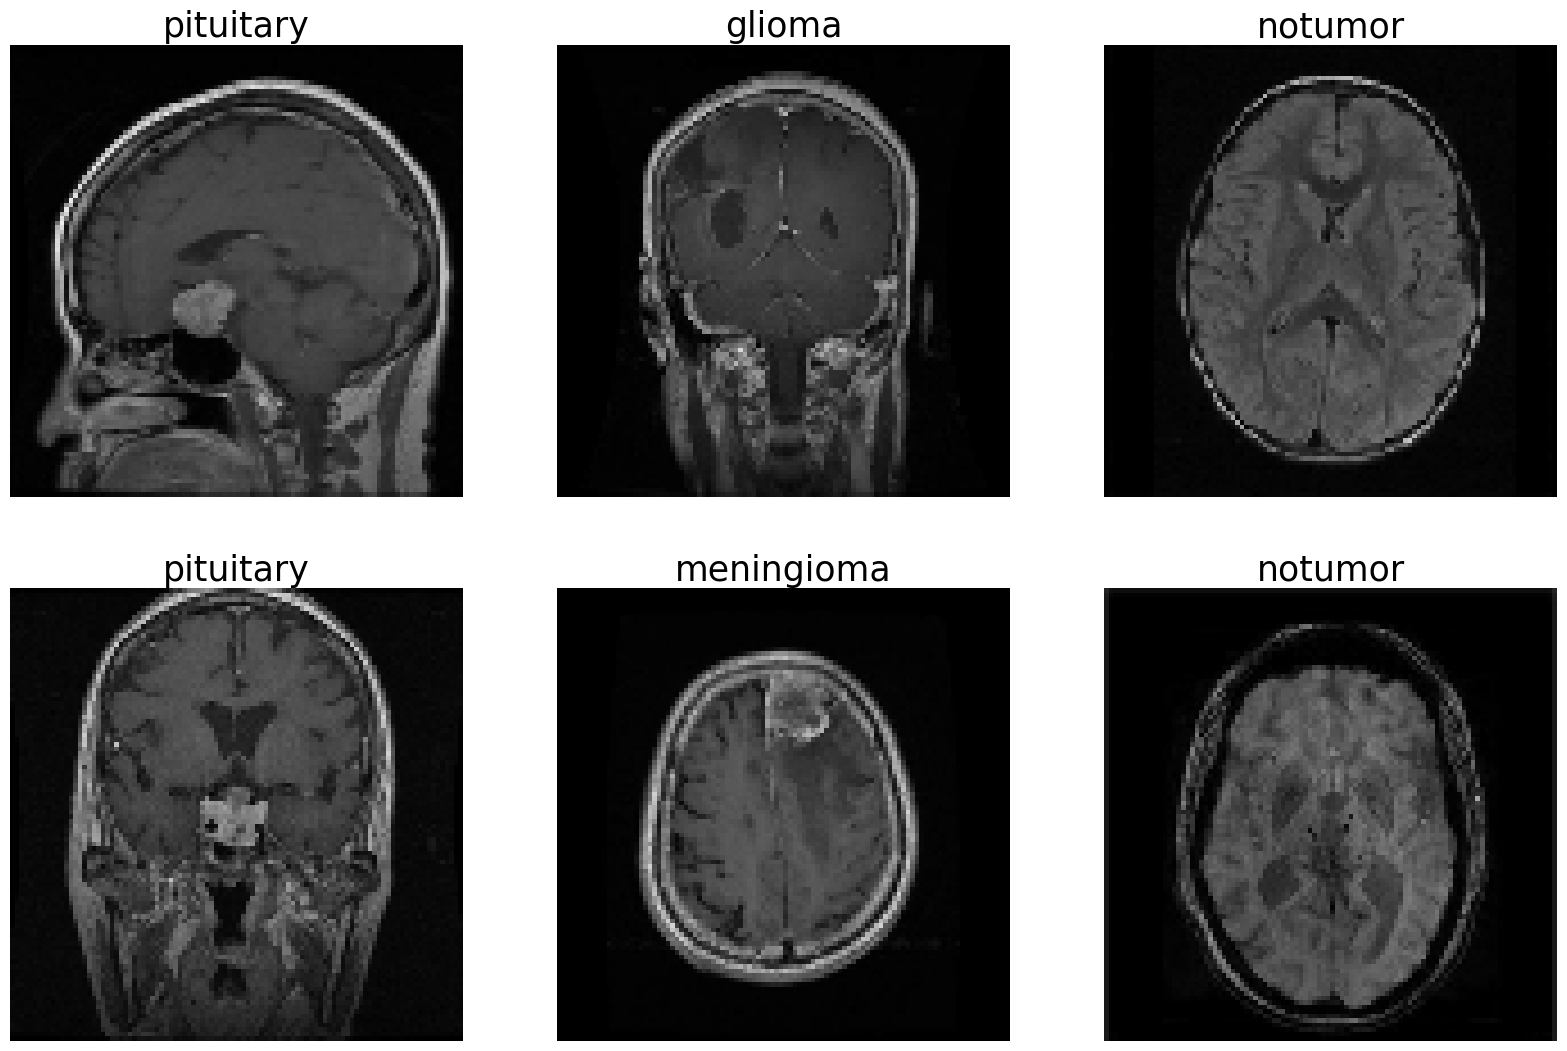

In [ ]:
#sample gambar dari masing masing kelas
attribute = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(100, 100),
    batch_size=32
)

plt.figure(figsize=(20,20))
for image, labels in attribute.take(1):
  for i in range (6):
    plt.subplot(3,3, i + 1)
    plt.imshow(np.array(image[i]).astype("uint8"))
    plt.title(attribute.class_names[labels[i]], size=25)
    plt.axis("off")

In [ ]:
#check image sizes
sizes = []

for class_path in train_dir.iterdir():
    if class_path.is_dir():
        for img_path in class_path.iterdir():
            if img_path.is_file():
                with Image.open(img_path) as img:
                    sizes.append(img.size)

# Lihat ukuran yang paling umum
size_counts = Counter(sizes).most_common(5)


In [10]:
#top 5 size gambar
size_counts

[((512, 512), 3955),
 ((225, 225), 268),
 ((630, 630), 77),
 ((236, 236), 53),
 ((201, 251), 43)]

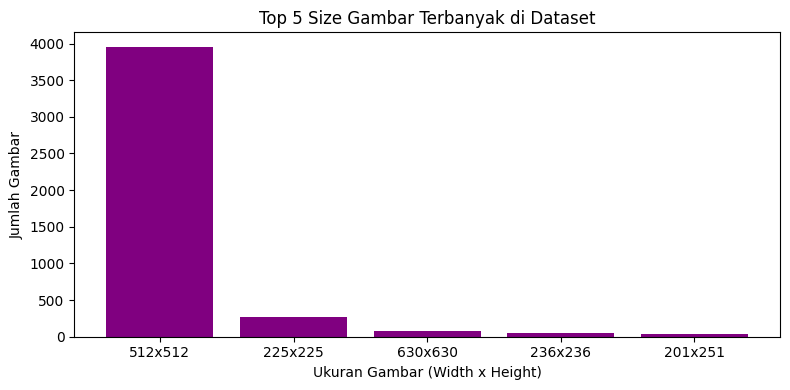

In [ ]:
labels = [f"{w}x{h}" for (w, h) in dict(size_counts).keys()]
counts = list(dict(size_counts).values())

# kalo dalam grafik
plt.figure(figsize=(8,4))
plt.bar(labels, counts, color='purple')
plt.title("Top 5 Size Gambar Terbanyak di Dataset")
plt.xlabel("Ukuran Gambar (Width x Height)")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

In [ ]:
#check gambar rusak
corrupt_files = []
for img_path in train_dir.rglob("*.*"):
    if img_path.is_file():
        try:
            with Image.open(img_path) as img:
                img.verify()
        except Exception:
            corrupt_files.append(str(img_path))

print(f"Jumlah gambar corrupt: {len(corrupt_files)}")


Jumlah gambar corrupt: 0


### Dataset Condition Conclusion:
Dataset terdiri dari empat kelas, yaitu glioma, meningioma, notumor, dan pituitary, dengan struktur direktori yang rapi di dalam folder Training dan Testing. Distribusi gambar pada masing-masing kelas tergolong seimbang, baik pada data Training maupun data TEsting, sehingga tidak ditemukan masalah class imbalance yang signifikan. Visualisasi sampel gambar menunjukkan bahwa gambar dapat dikenali dengan jelas, menandakan kualitas gambar yang baik untuk digunakan dalam pelatihan CNN. Meskipun terdapat variasi ukuran gambar, mayoritas berukuran 512x512 piksel, sehingga diperlukan proses resizing sebelum pelatihan model. Selain itu, tidak ditemukan gambar corrupt dalam dataset, sehingga data siap digunakan untuk proses selanjutnya.

Text(0, 0.5, 'Frequency')

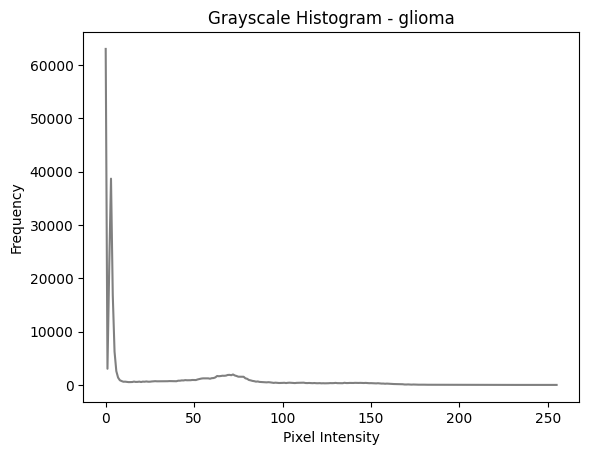

In [ ]:
def histogram(image_path):
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    return hist

class_path = train_dir / "glioma"
sample_image = list(class_path.glob('*.jpg'))[0] 
hist = histogram(sample_image)


plt.plot(hist, color='gray')
plt.title(f"Grayscale Histogram - glioma")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")


Text(0, 0.5, 'Frequency')

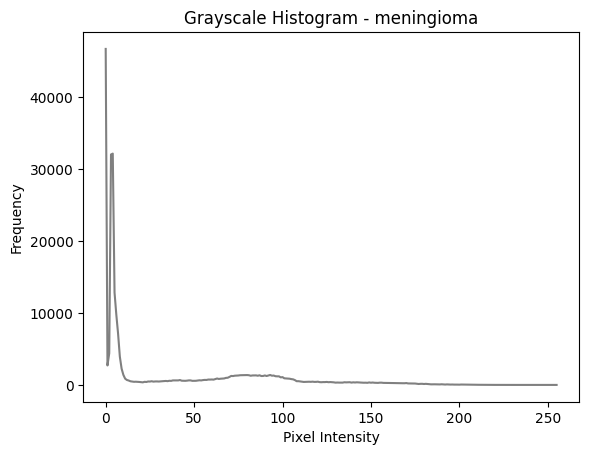

In [ ]:
class_path = train_dir / "meningioma"
sample_image = list(class_path.glob('*.jpg'))[0] 
hist = histogram(sample_image)

plt.plot(hist, color='gray')
plt.title(f"Grayscale Histogram - meningioma")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")


Text(0, 0.5, 'Frequency')

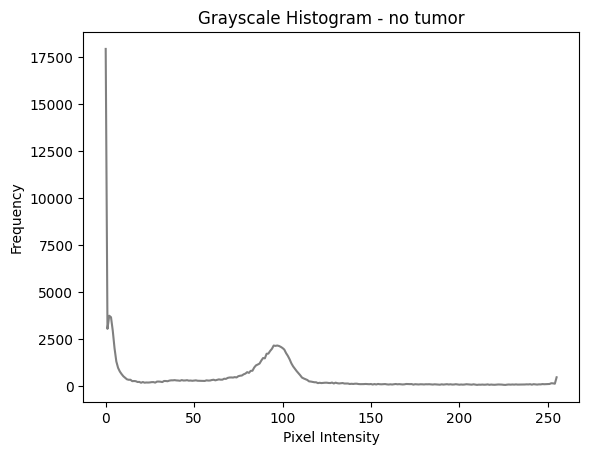

In [ ]:
class_path = train_dir / "notumor"
sample_image = list(class_path.glob('*.jpg'))[0] 
hist = histogram(sample_image)

plt.plot(hist, color='gray')
plt.title(f"Grayscale Histogram - no tumor")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

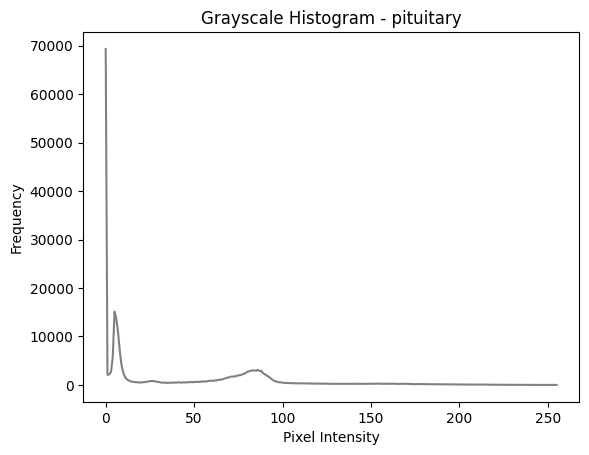

In [ ]:
class_path = train_dir / "pituitary"
sample_image = list(class_path.glob('*.jpg'))[0] 
hist = histogram(sample_image)

plt.plot(hist, color='gray')
plt.title(f"Grayscale Histogram - pituitary")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

### kesimpulan histogram:
- Gambar tumor (glioma, meningioma, pituitary) cenderung memiliki distribusi intensitas piksel yang terkonsentrasi di nilai-nilai rendah → banyak area gelap dan kontras tinggi.
- Gambar normal (no tumor) memiliki distribusi yang lebih menyebar, terutama di area tengah → menunjukkan pencahayaan lebih merata dan tidak ada massa abnormal.



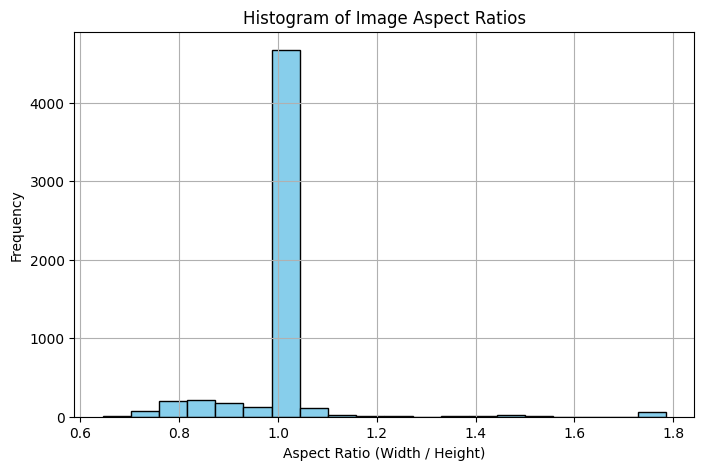

In [17]:
aspect_ratios = []
resolutions = []

for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)
    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)
        img = Image.open(img_path)
        w, h = img.size
        aspect_ratios.append(w / h)
        resolutions.append((w, h))

# Plot histogram aspect ratio
plt.figure(figsize=(8, 5))
plt.hist(aspect_ratios, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Image Aspect Ratios')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


aspect ratio didominasi dengan persegi, namun masih ada yang bukan, maka perlu dilakukan resizing ke bentuk persegi (misal: 224x224 atau 256x256) tidak akan terlalu mendistorsi gambar. di bagian preprocessing agar dataset seragam ukurannya.

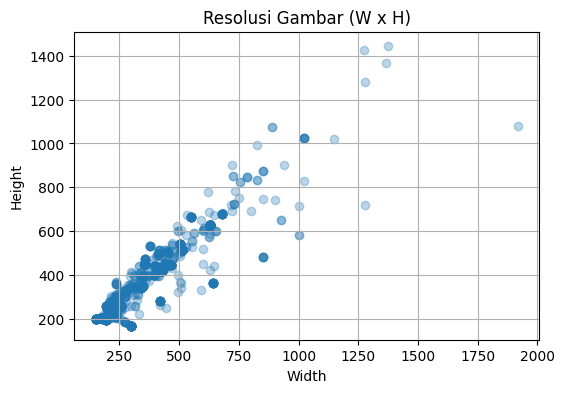

In [18]:
res_w, res_h = zip(*resolutions)
plt.figure(figsize=(6, 4))
plt.scatter(res_w, res_h, alpha=0.3)
plt.title("Resolusi Gambar (W x H)")
plt.xlabel("Width")
plt.ylabel("Height")
plt.grid()
plt.show()

Konsistensi resolusi ini mempermudah preprocessing, karena hanya perlu menerapkan resize standar (misalnya 224x224) pada seluruh gambar.


In [19]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_random_images_per_class(folder, n=4):
    class_names = os.listdir(folder)
    
    plt.figure(figsize=(n * 3, len(class_names) * 3))

    for row, cls in enumerate(class_names):
        cls_path = os.path.join(folder, cls)
        img_paths = [os.path.join(cls_path, f) for f in os.listdir(cls_path)]
        
        # Ambil n gambar acak dari tiap kelas
        random_imgs = random.sample(img_paths, min(n, len(img_paths)))
        
        for col, img_path in enumerate(random_imgs):
            idx = row * n + col + 1
            img = Image.open(img_path)
            plt.subplot(len(class_names), n, idx)
            plt.imshow(img)
            plt.axis('off')

            # Title per gambar
            plt.title(cls, fontsize=20)

    plt.suptitle("Contoh Gambar per Kelas", fontsize=22)
    plt.tight_layout()
    plt.show()


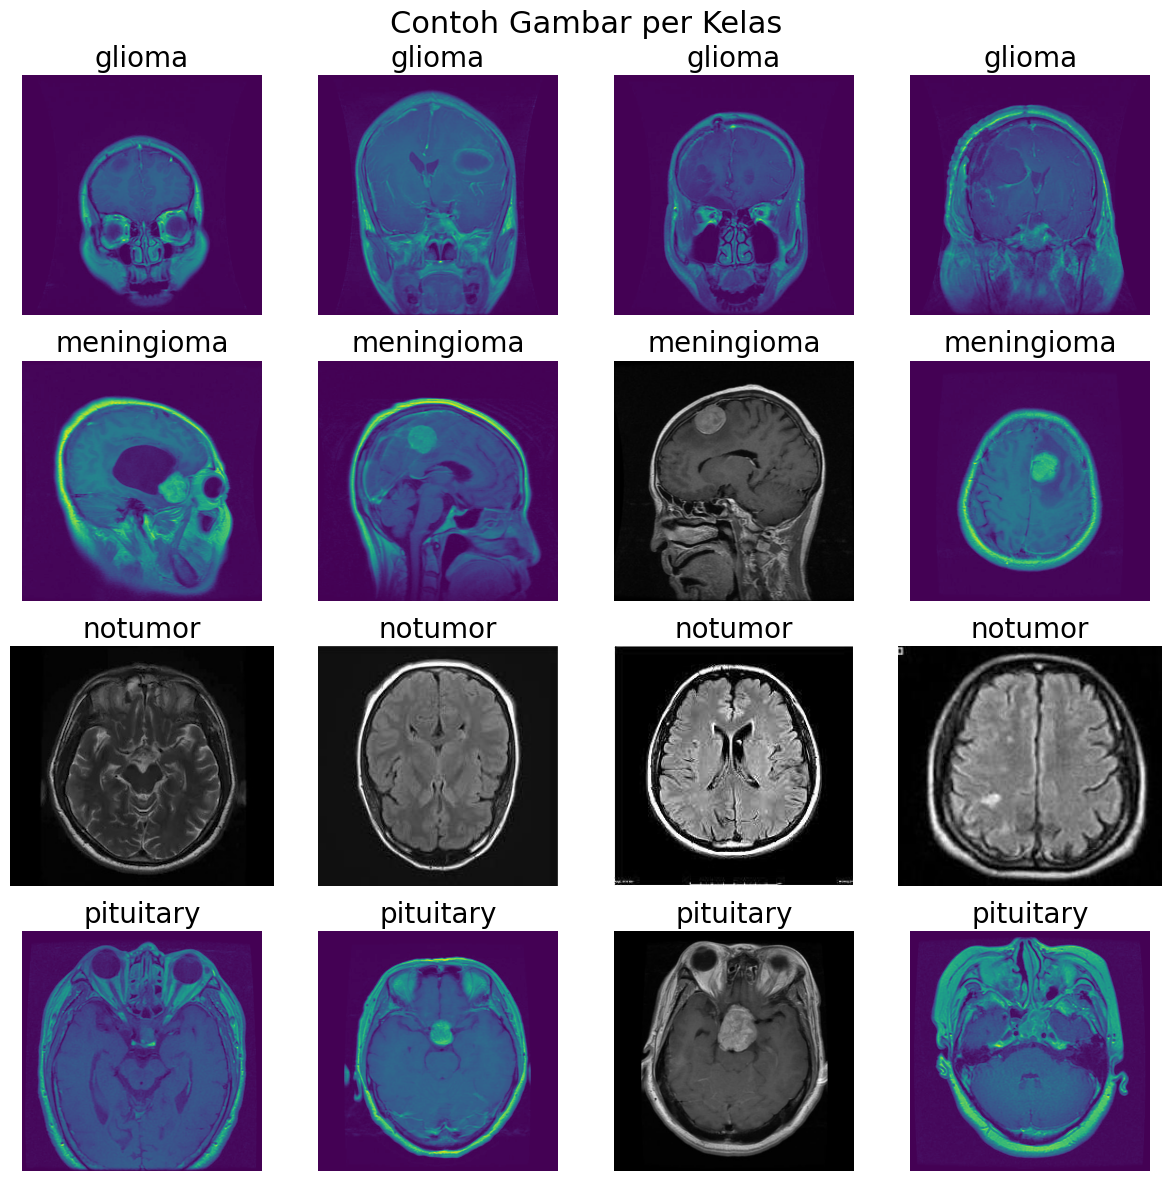

In [20]:
show_random_images_per_class(train_dir, n=4)

#### Kesimpulan:
Dataset ini memiliki variabilitas yang cukup baik dalam hal Sudut pandang (angle) MRI, Brightness / contrast, Tingkat kejelasan lesi, Teknik pengambilan gambar.

## Preprocessing

In [5]:
output_dir = Path(r'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Preprocessed')

In [ ]:
def process_and_save(image_path, dest_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224,224))
    dest_path.parent.mkdir(parents=True, exist_ok=True)
    img.save(dest_path)
    

In [13]:

val_ratio = 0.15

In [14]:
# Proses Train -> Train + Val
for class_dir in train_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob('*.jpg'))  # Sesuaikan ekstensi kalau perlu
        train_imgs, val_imgs = train_test_split(images, test_size=val_ratio, random_state=42)

        for img_path in train_imgs:
            dest = output_dir / 'train' / class_dir.name / img_path.name
            process_and_save(img_path, dest)

        for img_path in val_imgs:
            dest = output_dir / 'val' / class_dir.name / img_path.name
            process_and_save(img_path, dest)

In [15]:
# Proses Test (langsung salin semua)
for class_dir in test_dir.iterdir():
    if class_dir.is_dir():
        for img_path in class_dir.glob('*.jpg'):
            dest = output_dir / 'test' / class_dir.name / img_path.name
            process_and_save(img_path, dest)

In [16]:
train_dir = r'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Preprocessed\train'
val_dir = r'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Preprocessed\val'
test_dir = r'D:\binus\semester 4\Deep Learning\UTS\Nomor 2\Preprocessed\test'


In [ ]:
#rescale pixel jadi 0 1
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    'D:/binus/semester 4/Deep Learning/UTS/Nomor 2/Preprocessed/train',
    target_size=(224, 224), #make sure sizing correct
    batch_size=32, #ukuran batch 
    class_mode='categorical' # one hot encoding untuk class 
)

Found 4853 images belonging to 4 classes.


In [30]:
val_generator = val_datagen.flow_from_directory(
    'D:/binus/semester 4/Deep Learning/UTS/Nomor 2/Preprocessed/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 859 images belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    'D:/binus/semester 4/Deep Learning/UTS/Nomor 2/Preprocessed/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # data tidak diacak, agar urutan label cocok untuk evaluasi
)

Found 1311 images belonging to 4 classes.


## Baseline Model

In [32]:
input_shape=(224, 224, 3)
num_classes=4

In [33]:
model = models.Sequential()

In [34]:
# Layer 1
model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))


In [35]:
# Layer 2
model.add(layers.Conv2D(256, (5, 5), padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))


In [36]:
# Layer 3
model.add(layers.Conv2D(384, (3, 3), padding="same", activation='relu'))

In [37]:
# Layer 4
model.add(layers.Conv2D(384, (3, 3), padding="same", activation='relu'))

In [38]:
# Layer 5
model.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

In [39]:
# Flatten & Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))  # 4 kelas

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [42]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


152/152 [==============================] - 240s 2s/step - loss: 1.2749 - accuracy: 0.3878 - val_loss: 1.1060 - val_accuracy: 0.4435
Epoch 2/10
152/152 [==============================] - 242s 2s/step - loss: 1.0746 - accuracy: 0.5189 - val_loss: 0.9929 - val_accuracy: 0.5809
Epoch 3/10
152/152 [==============================] - 232s 2s/step - loss: 0.7109 - accuracy: 0.7226 - val_loss: 0.5827 - val_accuracy: 0.7485
Epoch 4/10
152/152 [==============================] - 233s 2s/step - loss: 0.4617 - accuracy: 0.8341 - val_loss: 0.4199 - val_accuracy: 0.8626
Epoch 5/10
152/152 [==============================] - 234s 2s/step - loss: 0.3712 - accuracy: 0.8718 - val_loss: 0.3560 - val_accuracy: 0.8836
Epoch 6/10
152/152 [==============================] - 231s 2s/step - loss: 0.3339 - accuracy: 0.8821 - val_loss: 0.3760 - val_accuracy: 0.8696
Epoch 7/10
152/152 [==============================] - 232s 2s/step - loss: 0.2906 - accuracy: 0.8994 - val_loss: 0.2602 - val_accuracy: 0.91

- Model berhasil belajar dengan sangat baik.
- Akurasi tinggi pada training dan validation set → Menunjukkan model cukup kuat untuk klasifikasi 4 kelas tumor otak.
- Tidak ada overfitting yang parah (selisih training vs validation kecil).

## Moded

#### Modifikasi yang saya lakukan:
- Tambah Batch Normalization setelah beberapa Conv layer → bantu training lebih stabil dan lebih cepat konvergen
- Ganti optimizer ke SGD dengan momentum sebagai eksperimen fine-tuning (lebih dekat ke original AlexNet)
- Sedikit turunkan Dense layer dari 4096 jadi 2048 supaya lebih ringan (AlexNet zaman sekarang biasanya di-trim kayak gitu)


In [43]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD

In [44]:
model_moded = models.Sequential()

In [46]:
# Layer 1
model_moded.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
model_moded.add(layers.BatchNormalization())
model_moded.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

In [47]:
# Layer 2
model_moded.add(layers.Conv2D(256, (5, 5), padding="same", activation='relu'))
model_moded.add(layers.BatchNormalization())
model_moded.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

In [48]:
# Layer 3
model_moded.add(layers.Conv2D(384, (3, 3), padding="same", activation='relu'))


In [49]:
# Layer 4
model_moded.add(layers.Conv2D(384, (3, 3), padding="same", activation='relu'))


In [50]:
# Layer 5
model_moded.add(layers.Conv2D(256, (3, 3), padding="same", activation='relu'))
model_moded.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))


In [51]:
# FC Layers
model_moded.add(layers.Flatten())
model_moded.add(layers.Dense(2048, activation='relu'))
model_moded.add(layers.Dropout(0.5))
model_moded.add(layers.Dense(2048, activation='relu'))
model_moded.add(layers.Dropout(0.5))
model_moded.add(layers.Dense(num_classes, activation='softmax'))  # 4 classes


In [52]:
# Compile with SGD + momentum (classic AlexNet style)
model_moded.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
model_moded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 54, 54, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 26, 26, 256)       1024      
 chNormalization)                                                
                                                      

In [54]:
history_moded = model_moded.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
152/152 [==============================] - 200s 1s/step - loss: 0.9936 - accuracy: 0.6126 - val_loss: 0.8649 - val_accuracy: 0.6717
Epoch 2/10
152/152 [==============================] - 204s 1s/step - loss: 0.5782 - accuracy: 0.7781 - val_loss: 0.5937 - val_accuracy: 0.7672
Epoch 3/10
152/152 [==============================] - 202s 1s/step - loss: 0.4480 - accuracy: 0.8302 - val_loss: 0.3970 - val_accuracy: 0.8347
Epoch 4/10
152/152 [==============================] - 201s 1s/step - loss: 0.3409 - accuracy: 0.8716 - val_loss: 0.3288 - val_accuracy: 0.8673
Epoch 5/10
152/152 [==============================] - 203s 1s/step - loss: 0.2844 - accuracy: 0.8999 - val_loss: 0.2245 - val_accuracy: 0.9162
Epoch 6/10
152/152 [==============================] - 203s 1s/step - loss: 0.2315 - accuracy: 0.9182 - val_loss: 0.1958 - val_accuracy: 0.9313
Epoch 7/10
152/152 [==============================] - 203s 1s/step - loss: 0.1817 - accuracy: 0.9353 - val_loss: 0.3183 - val_accuracy: 0.8964

Pada epoch ke-10, model mencapai akurasi training sebesar 95.2% dan akurasi validasi sebesar 93.4%, yang menunjukkan performa yang sangat baik. Nilai val_loss juga rendah di angka 0.1921, menandakan bahwa model tidak mengalami overfitting secara signifikan. Hal ini menunjukkan bahwa model mampu belajar secara efektif dan memiliki kemampuan generalisasi yang kuat terhadap data yang belum pernah dilihat sebelumnya.

## Evaluasi

In [55]:
Y_pred = model_moded.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Ambil kelas dengan probabilitas tertinggi


41/41 [==============================] - 21s 520ms/step


In [56]:
y_true = test_generator.classes

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [59]:
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9230


In [60]:
class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.88      0.91       300
  meningioma       0.88      0.82      0.85       306
     notumor       0.92      0.99      0.95       405
   pituitary       0.96      0.98      0.97       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



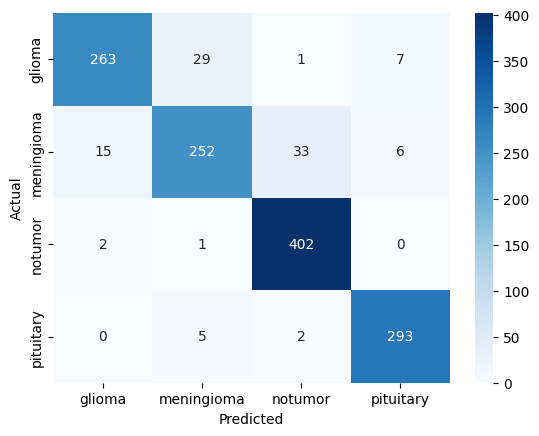

In [65]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Berdasarkan hasil evaluasi model, terlihat bahwa model memiliki performa yang sangat baik dengan akurasi sebesar 92.3%. Ini menunjukkan bahwa mayoritas prediksi model sudah sesuai dengan label sebenarnya. Selain akurasi, metrik precision, recall, dan f1-score juga menunjukkan hasil yang konsisten dan tinggi di semua kelas. Kelas "notumor" dan "pituitary" memiliki performa terbaik, dengan f1-score masing-masing sebesar 0.95 dan 0.97, yang berarti model sangat akurat dan konsisten dalam mengenali dua kelas ini. Namun, kelas "meningioma" masih menjadi tantangan karena recall-nya lebih rendah (0.82), menandakan bahwa model cukup sering salah mengenali meningioma sebagai kelas lain, terutama "notumor". Meski begitu, rata-rata makro dari semua metrik utama berada di angka 0.92, yang menandakan bahwa model memiliki kinerja seimbang di seluruh kelas. Secara keseluruhan, model ini sudah sangat baik dan layak untuk digunakan lebih lanjut, meskipun masih bisa ditingkatkan khususnya dalam membedakan meningioma.